# Notebook 1: Estimating Rates

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Poisson process

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\mu$, in goals per game.

To get started, let's assume that $\mu$ is somehow known to be 2.4 goals per game.

We can use SciPy to generate a sample from a Poisson distribution.

In [124]:
from scipy.stats import poisson

mu = 2.4
sample_poisson = poisson.rvs(mu, size=1000)
np.mean(sample_poisson)

2.415

To show the distribution of the quantities, I'll use the following function, which returns a Pandas `Series`.

In [4]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

The index of the `Series` contains the possible quantities; the values in the `Series` are their probabilities.

In [5]:
pmf_poisson = make_pmf(sample_poisson)
pmf_poisson

0    0.107
1    0.200
2    0.281
3    0.194
4    0.125
5    0.056
6    0.030
7    0.004
8    0.003
dtype: float64

The following function takes a sample and plots the PMF as a bar chart.

In [6]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

And this one decorates the axes.

In [7]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

Here's what the distribution looks like.

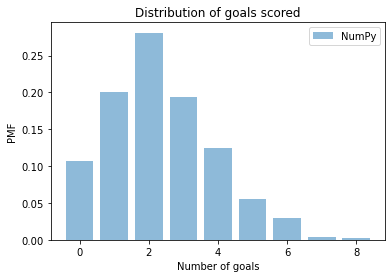

In [8]:
plot_pmf(sample_poisson, label='SciPy', alpha=0.5)
decorate_goals()

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [9]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

This example runs the model forward and puts the results into `trace`, which is a mapping type.

In [10]:
len(trace['goals'])

1000

In [11]:
sample_pymc = trace['goals']
np.mean(sample_pymc)

2.418

The results from PyMC are similar to what we got from SciPy.

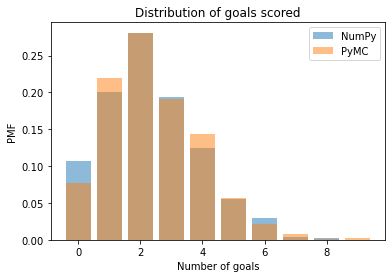

In [12]:
plot_pmf(sample_poisson, label='SciPy', alpha=0.5)
plot_pmf(sample_pymc, label='PyMC', alpha=0.5)
decorate_goals('PMF')

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its PMF analytically, and SciPy provides an implementation.

In [85]:
from scipy.stats import poisson

mu = 2.4
xs = np.arange(11)
ps = poisson.pmf(xs, mu)

Here's the analytic distribution we just computed compared to the PMF of the sample.

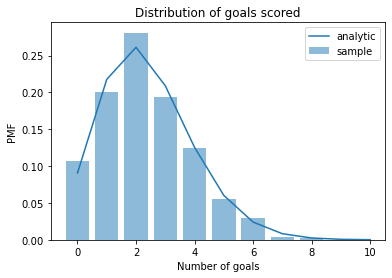

In [86]:
plot_pmf(sample_poisson, label='sample', alpha=0.5)
plt.plot(xs, ps, label='analytic')

decorate_goals()

## The Likelihood Function

We can also use the analytic PMF to compute the probability of a given outcome.

For example, here's the probability of scoring 4 goals in a game if the long-term rate is 2.4 goals per game.

In [87]:
data = 4
poisson.pmf(data, mu)

0.1254084986272838

And here's the likelihood of 4 goals for a range of possible values of `mu`.

In [88]:
mus = np.linspace(0, 15, num=101)
likelihood = poisson.pmf(4, mus)

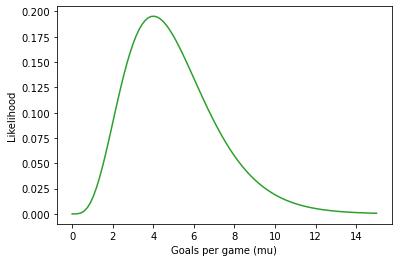

In [89]:
plt.plot(mus, likelihood, color='C2')
plt.xlabel('Goals per game (mu)')
plt.ylabel('Likelihood');

This graph shows the likelihood function we can use to do a Bayesian update.

## Bayesian inference with grid approximation

It's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

We can use `make_gamma_pmf` to construct a prior PMF with given parameters.

In [90]:
from scipy.stats import gamma

def make_gamma_pmf(qs, alpha, beta):
    """Makes a PMF based on a gamma distribution.
    
    qs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: pd.Series
    """
    ps = gamma(a=alpha, scale=1/beta).pdf(qs)
    pmf = pd.Series(ps, index=qs)
    pmf /= pmf.sum()
    return pmf

Here's what it looks like with parameters I chose based on what I know about goal-scoring rates in hockey.

In [91]:
alpha = 4.4
beta = 1.8

mus = np.linspace(0, 10, num=101)
prior = make_gamma_pmf(mus, alpha, beta)

Here's what it looks like.

In [92]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

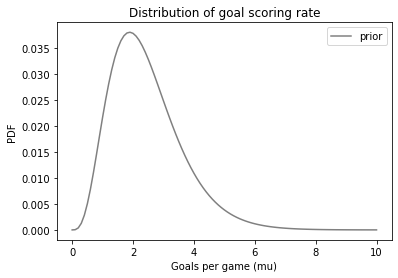

In [93]:
prior.plot(label='prior', color='gray')
decorate_rate()

This prior implies that goal-scoring rates (between professional teams) are typically between 1 and 5 goals per game.

Now we can update it with data. Suppose one team scores 4 goals against another. What should we believe about `mu`?

In [94]:
data = 4
likelihood = poisson.pmf(data, mus)

In [95]:
posterior = prior * likelihood
posterior /= posterior.sum()

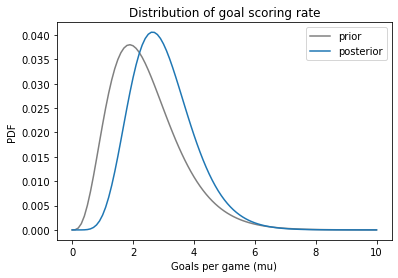

In [96]:
prior.plot(color='gray', label='prior')
posterior.plot(label='posterior')
decorate_rate()

The distribution has shifted to the right.

In [97]:
prior.idxmax(), posterior.idxmax()

(1.9000000000000001, 2.6)

The peak is at 2.6, which is between the prior and the data.

Before we go on, I'll generate a sample from the prior, which we will compare to results from PyMC.

In [98]:
def sample_pmf(pmf, size):
    """Draw a sample from a PMF.
    
    pmf: Pandas Series
    size: number of elements
    
    returns: NumPy array
    """
    return np.random.choice(pmf.index, size, p=pmf.values)

In [99]:
sample_prior_grid = sample_pmf(prior, 1000)
sample_prior_grid.mean()

2.4467000000000003

And a sample from the posterior distribution.

In [100]:
sample_post_grid = sample_pmf(posterior, 1000)
sample_post_grid.mean()

3.0321000000000002

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here's what the PyMC model looks like:

In [101]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [102]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

2.4669554496653086

And compare it to the sample we drew from the gamma prior.

In [103]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

In [104]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

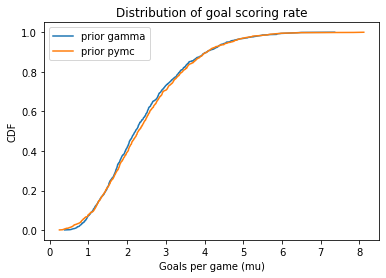

In [105]:
plot_cdf(sample_prior_gamma, label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

Looks good.

## The prior predictive distribution

This model actually generates two variables:

1. Values of `mu` drawn from the prior distribution.

2. Values of `goals` drawn from the prior predictive distribution.

Remember that `mu` is a rate in goals per game, and `goals` is an integer number of goals.

We can get a sample of `goals` from the trace.

In [106]:
sample_prior_pred = trace['goals']
sample_prior_pred.mean()

2.516

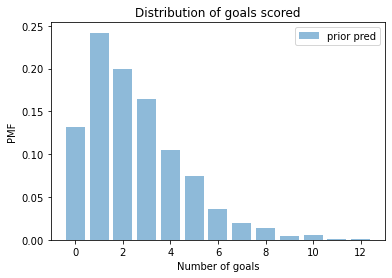

In [107]:
plot_pmf(sample_prior_pred, label='prior pred', alpha=0.5)
decorate_goals()

This distribution shows the distribution of goals we should expect in a game, based on the prior distribution only, not the data.

It is useful for model-checking, but it is also a step along the way to inference.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [108]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  

In [109]:
len(trace['mu'])

2000

We can plot the posterior using a function provided by PyMC:

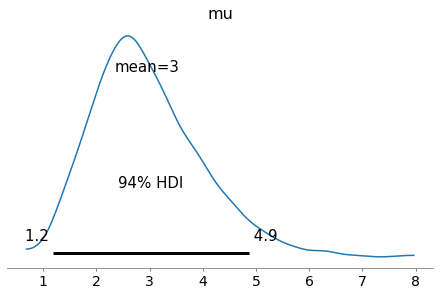

In [110]:
import arviz as az

with model:
    az.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [111]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

2.9548878254856064

And compare it to a sample from the grid approximation:

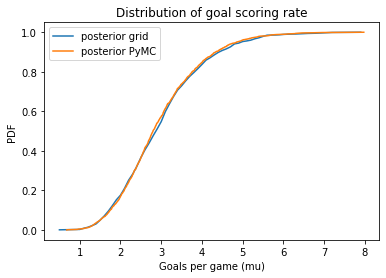

In [112]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

Again, it looks pretty good.

**Exercise:** The example we've run so far is based on three parameters: the values of `alpha` and `beta` that determine the prior distribution, and the observed number of goals.

Modify any of these variables and run the example again to see what effect they have.

## Two teams

We can extend the model to estimate different values of `mu` for two teams.

In [120]:
alpha = 4.4
beta = 1.8

In [121]:
model = pm.Model()

with model:
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    mu_MTL = pm.Gamma('mu_MTL', alpha, beta)
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[5])
    goals_MTL = pm.Poisson('goals_MTL', mu_MTL, observed=[1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_MTL, mu_TBL]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `traceplot` to review the results and do some visual diagnostics.

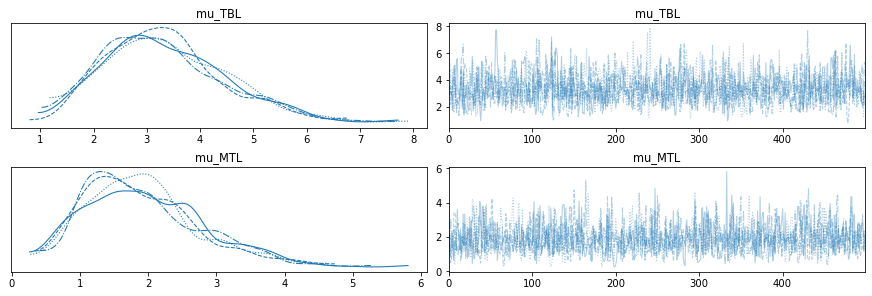

In [122]:
with model:
    az.plot_trace(trace);

Here are the posterior distribitions for `mu_MTL` and `mu_TBL`.

(1.9150804344081036, 3.3807649870934307)

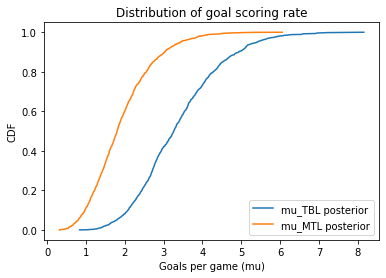

In [118]:
mu_TBL = trace['mu_TBL']
plot_cdf(mu_TBL, label='mu_TBL posterior')

mu_MTL = trace['mu_MTL']
plot_cdf(mu_MTL, label='mu_MTL posterior')

decorate_rate('CDF')
np.mean(mu_MTL), np.mean(mu_TBL)

On the basis of these two games, here's the probability that Tampa Bay is the better team.

In [119]:
np.mean(mu_TBL > mu_MTL)

0.863

**Exercise:** Modify the previous example to take into account both games. How much does the second game affect the "probability of superiority"?

Hint: The observed data can be a list.